## Introduction
We are ready to train the Cardiac Detection Model now!

In [48]:
!pip install pytorch-lightning --upgrade

In [1]:
import torch
import torchvision
import pytorch_lightning as pl #to handle training
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import cv2
import imgaug.augmenters as iaa
from dataset import CardiacDataset


In [2]:
!pip install jmespath

## Imports:

* torch and torchvision for model and dataloader creation
* pytorch lightning for efficient and easy training implementation
* ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
* numpy data loading
* cv2 for drawing rectangles on images
* imgaug for augmentation pipeline
* Our CardiacDataset



We create the dataset objects and the augmentation parameters to specify the augmentation parameters

In [3]:
train_root_path = "Processed-Heart-Detection/train/"
train_subjects = "train_subjects.npy"
val_root_path = "Processed-Heart-Detection/val/"
val_subjects = "val_subjects.npy"

train_transforms = iaa.Sequential([
                                iaa.GammaContrast(),
                                iaa.Affine(
                                    scale=(0.8, 1.2),
                                    rotate=(-10, 10),
                                    translate_px=(-10, 10)
                                )
                            ])

In [4]:
train_dataset = CardiacDataset("rsna_heart_detection.csv", train_subjects, train_root_path, train_transforms)
val_dataset = CardiacDataset("rsna_heart_detection.csv", val_subjects, val_root_path, None)#no augs for valid

In [5]:
batch_size = 8
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [6]:
train_dataset = CardiacDataset(
    "./rsna_heart_detection.csv",
     train_subjects,
     train_root_path,
     augs = train_transforms)

val_dataset = CardiacDataset(
    "./rsna_heart_detection.csv",
     val_subjects,
     val_root_path,
     augs=None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 400 train images and 96 val images


Adapt batch size and num_workers according to your computing hardware.

In [7]:
batch_size = 8#TODO
num_workers = 2# TODO


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


## Model Creation

We use the same architecture as we used in the classifcation task with some small adaptations:

1. 4 outputs: Instead of predicting a binary label we need to estimate the location of the heart (xmin, ymin, xmax, ymax).
2. Loss function: Instead of using a cross entropy loss, we are going to use the L2 loss (Mean Squared Error), as we are dealing with continuous values.

In [8]:
class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18(pretrained=True)
        
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 4 bbox
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4) #0.0001
        self.loss_fn = torch.nn.MSELoss()
    
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray) #forward short hand is self
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss
        self.log("Train Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")

        return loss
    
        
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label

        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        
        loss = self.loss_fn(pred, label)
        self.log("Val Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss
    
    def log_images(self, x_ray, pred, label, name):
        results = []
        
        # Here we create a grid consisting of 4 predictions
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            img = ((x_ray[i] * 0.252)+0.494).numpy()[0] #get rid of channel dimension
            
            # Extract the coordinates from the label
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            # Extract the coordinates from the prediction           
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)
            
            
            results.append(torch.tensor(img).unsqueeze(0))
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(f"{name} Prediction vs Label", grid, self.global_step)

            
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]



In [9]:
# Create the model object
model = CardiacDetectionModel()  # Instanciate the model

C:\Users\jaikr\.conda\envs\Jupyter_1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jaikr\.conda\envs\Jupyter_1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss',
    save_top_k=10,
    mode='min')

Train for at least 50 epochs to get a decent result.
100 epochs lead to great results.

You can train this on a CPU!

In [12]:
# Create the trainer
# Change the gpus parameter to the number of available gpus in your computer. Use 0 for CPU training

gpus = 1 #TODO
trainer = pl.Trainer( logger=TensorBoardLogger("./logs"), log_every_n_steps=1,
                     default_root_dir="./weights", callbacks=checkpoint_callback,
                     max_epochs=60)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [47]:
!pip install -U tensorboard

     ---------------------------------------- 0.0/181.3 kB ? eta -:--:--
     ----------------- --------------------- 81.9/181.3 kB 2.3 MB/s eta 0:00:01
     -------------------------------------- 181.3/181.3 kB 2.8 MB/s eta 0:00:00
     ---------------------------------------- 0.0/83.9 kB ? eta -:--:--
     ---------------------------------------- 83.9/83.9 kB 4.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/5.5 MB ? eta -:--:--
   --- ------------------------------------ 0.5/5.5 MB 14.2 MB/s eta 0:00:01
   ------ --------------------------------- 1.0/5.5 MB 12.2 MB/s eta 0:00:01
   ---------- ----------------------------- 1.5/5.5 MB 11.6 MB/s eta 0:00:01
   ------------- -------------------------- 1.9/5.5 MB 11.2 MB/s eta 0:00:01
   ----------------- ---------------------- 2.4/5.5 MB 11.1 MB/s eta 0:00:01
   --------------------- ------------------ 2.9/5.5 MB 11.1 MB/s eta 0:00:01
   ------------------------ --------------- 3.4/5.5 MB 10.8 MB/s eta 0:00:01
   ----

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
onnxruntime 1.15.1 requires flatbuffers, which is not installed.
google-cloud-logging 2.7.2 requires protobuf<4.0.0dev, but you have protobuf 4.23.4 which is incompatible.
mysql-connector-python 8.0.32 requires protobuf<=3.20.3,>=3.11.0, but you have protobuf 4.23.4 which is incompatible.


In [13]:
# Train the detection model
trainer.fit(model, train_loader, val_loader)

Missing logger folder: ./logs\lightning_logs

  | Name    | Type    | Params
------------------------------------
0 | model   | ResNet  | 11.2 M
1 | loss_fn | MSELoss | 0     
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.689    Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\jaikr\.conda\envs\Jupyter_1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
C:\Users\jaikr\.conda\envs\Jupyter_1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

C:\Users\jaikr\.conda\envs\Jupyter_1\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Evaluation

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CardiacDetectionModel.load_from_checkpoint("weight.ckpt")

model.eval();
model.to(device)

C:\Users\jaikr\.conda\envs\Jupyter_1\lib\site-packages\pytorch_lightning\utilities\migration\migration.py:207: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.3.5 to v2.1.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint D:\Udemy-Medical PyTorch\05-Detection\05-Detection\weight.ckpt`


CardiacDetectionModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

Compute prediction for all validation samples

In [21]:
preds = []
labels = []

with torch.no_grad():
    for data, label in val_dataset:
        data = data.to(device).float().unsqueeze(0)
        pred = model(data)[0].cpu()
        preds.append(pred)
        labels.append(label)
        
preds=torch.stack(preds)
labels=torch.stack(labels)

Compute mean deviation between prediction and labels for each coordinate

In [22]:
abs(preds-labels).mean(0)

tensor([8.3512, 5.5593, 5.9868, 5.7377])

Example prediction:

tensor([ 96,  62, 172, 147])


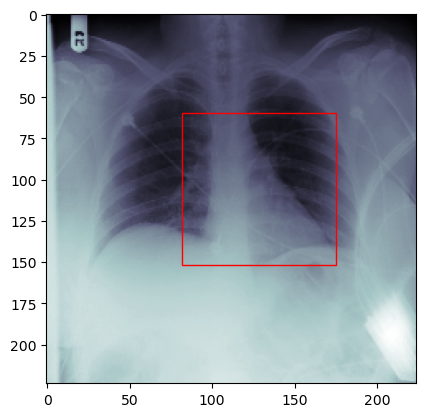

In [27]:
IDX = 95  # Feel free to inspect all validation samples by changing the index
img, label = val_dataset[IDX]
current_pred = preds[IDX]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
heart = patches.Rectangle((current_pred[0], current_pred[1]), current_pred[2]-current_pred[0],
                          current_pred[3]-current_pred[1], linewidth=1, edgecolor='r', facecolor='none')
axis.add_patch(heart)

print(label)

Awesome, looks like we got a working heart detection!

#### HEART DETECTION IN X-RAYS - ResNet18